In [1]:
import importlib  

keras_deeplab = importlib.import_module("keras-deeplab-v3-plus.model")


import Keras_segmentation_deeplab_v3_1.utils

Version 2.x.x


In [2]:
from keras.optimizers import Adam
from utils.keras_functions import sparse_crossentropy_ignoring_last_label, sparse_accuracy_ignoring_last_label, Jaccard

image_size = (512,512)
monitor = 'Jaccard'
mode = 'max'

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard]}


deeplab_model = keras_deeplab.Deeplabv3(backbone='xception', input_shape=(512, 512, 3), classes=19, weights='cityscapes', infer=False)

deeplab_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
          loss = losses, metrics = metrics)

Cityscapes!


In [3]:
deeplab_model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [3]:
SegClass = Keras_segmentation_deeplab_v3_1.utils.SegModel("../kitti360_dataset_truncated.csv", image_size=image_size)

In [4]:
train_generator = SegClass.create_generators(dataset = "../kitti360_dataset_truncated.csv", blur=0, mode='train',
                                                n_classes=19, horizontal_flip=False, vertical_flip=False, 
                                                brightness=0, rotation=False, zoom=0, batch_size=4,
                                                seed=7, do_ahisteq=False)

In [5]:
X, y = train_generator.__getitem__(1)

print(X.shape)
print(y.shape)

(4, 512, 512, 3)
(4, 262144, 1)


In [6]:
a = deeplab_model.predict(X)

In [7]:
sparse_crossentropy_ignoring_last_label(y,a)

(4, 262144, 1)
Instructions for updating:
Use `tf.cast` instead.
(4, 262144, 19)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]], shape=(4, 262144, 18), dtype=float32)


<tf.Tensor: shape=(4, 262144), dtype=float32, numpy=
array([[0.70612794, 0.43654826, 0.28456676, ..., 3.2835248 , 3.0067012 ,
        2.8167918 ],
       [0.14266029, 0.07611703, 0.04672918, ..., 3.4975288 , 3.2257504 ,
        2.9915757 ],
       [0.1764444 , 0.07760165, 0.04103755, ..., 2.6741943 , 2.4840875 ,
        2.3830051 ],
       [0.15914138, 0.06059663, 0.02568557, ..., 2.673223  , 2.4249182 ,
        2.2350705 ]], dtype=float32)>

In [20]:
if tf.__version__[0] == "2":
    _IS_TF_2 = True
    import tensorflow as tf
    import keras.backend as K
    from tensorflow.python.client import device_lib
else:
    _IS_TF_2 = False
    from tensorflow.python.client import device_lib



def Jaccardd(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    pred_pixels = K.argmax(y_pred, axis=-1)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(y_true[:,:,0], i)
        pred_labels = K.equal(pred_pixels, i)
        inter = tf.compat.v1.to_int32(true_labels & pred_labels)
        union = tf.compat.v1.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.compat.v1.to_int32(true_labels), axis=1)>0
        print(legal_batches)
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        if _IS_TF_2:
            iou.append(K.mean(ious[legal_batches]))
        else:
            iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou) if _IS_TF_2 else ~tf.debugging.is_nan(iou)
    iou = iou[legal_labels] if _IS_TF_2 else tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

Jaccardd(y,a)

tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False False False], shape=(4,), dtype=bool)
tf.Tensor([False False F

<tf.Tensor: shape=(), dtype=float64, numpy=0.49436133606936006>

In [20]:
import numpy as np
print(a.shape)
print(y.shape)
print(np.argmax(a, axis=-1).shape)

(4, 262144, 19)
(4, 262144, 1)
(4, 262144)


In [20]:
h = deeplab_model.fit(X, y, verbose=1, 
                      batch_size = 4, epochs = 1)

ValueError: in user code:

    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/src/utils/keras_functions.py:45 sparse_accuracy_ignoring_last_label  *
        y_true = K.reshape(y_true, (-1, nb_classes))
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:3020 reshape
        return array_ops.reshape(x, shape)
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:8377 reshape
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/pimonteiro/repos/Semantic-Segmentation-Thesis/venv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension size must be evenly divisible by 19 but is 1048576 for '{{node Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](Cast_4, Reshape_1/shape)' with input shapes: [4,262144,1], [2] and with input tensors computed as partial shapes: input[1] = [?,19].


In [6]:
steps = len(train_generator)
h = deeplab_model.fit_generator(train_generator,
                        steps_per_epoch=steps, 
                        epochs = 1, verbose=2, 
                        max_queue_size=10)


Instructions for updating:
Use `tf.cast` instead.
144/144 [==============================] - 101s 348ms/step - loss: 1.3058 - Jaccard: 0.2711
End of epoch...


In [9]:
sparse_crossentropy_ignoring_last_label(y, a)

Instructions for updating:
Use `tf.cast` instead.


<tf.Tensor: shape=(4, 262144), dtype=float32, numpy=
array([[0.06725656, 0.03333552, 0.01926454, ..., 0.        , 0.        ,
        0.        ],
       [0.04936893, 0.02447182, 0.01324119, ..., 0.        , 0.        ,
        0.        ],
       [0.15068753, 0.04880243, 0.01665424, ..., 1.8776833 , 1.6613352 ,
        1.4715773 ],
       [0.06005228, 0.02710054, 0.01358583, ..., 0.05035745, 0.07037152,
        0.10081109]], dtype=float32)>

In [19]:
import tensorflow.keras.backend as K

def new_sparse_accuracy_ignoring_last_label(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]

    y_pred = K.reshape(y_pred, (-1, nb_classes))
    print(y_pred[0])
    
    y_true = K.reshape(y_true, (-1, nb_classes))
    print(y_true.shape)
    
    legal_labels = K.greater(K.sum(y_true, axis=-1), 0)
    return K.sum(tf.compat.v1.to_float(legal_labels & K.equal(K.argmax(y_true, axis=-1),
                                                    K.argmax(y_pred, axis=-1)))) / K.sum(tf.compat.v1.to_float(legal_labels))

new_sparse_accuracy_ignoring_last_label(y,a)

tf.Tensor(
[1.1900296e-02 3.2291368e-03 1.3402537e-02 5.3937815e-04 3.4155758e-04
 2.0666759e-02 8.6651533e-04 6.9782685e-04 9.3495530e-01 3.0979333e-03
 1.1558343e-03 1.7672849e-03 8.5163722e-04 2.0334306e-03 9.7299693e-04
 8.8854291e-04 1.6752094e-04 9.6494763e-04 1.5005572e-03], shape=(19,), dtype=float32)


InvalidArgumentError: Input to reshape is a tensor with 1048576 values, but the requested shape requires a multiple of 19 [Op:Reshape]

In [11]:
Jaccard(y,a)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3751118069434505>

In [25]:
import cv2
import numpy as np

label = cv2.imread("mnt/7BCDA59C6DEFFE3C/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/0000007626.png", 0)
label = cv2.resize(label, (512,512), interpolation = cv2.INTER_NEAREST)
print(label)

labels = np.unique(label)

for j in np.setxor1d(np.unique(label), labels):
    print(j)
    label[label==j] = self.n_classes
print(label)

[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]]
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]]


In [35]:
from keras.optimizers import Adam
from utils.keras_functions import sparse_crossentropy_ignoring_last_label, sparse_accuracy_ignoring_last_label, Jaccard

image_size = (512,512)
monitor = 'Jaccard'
mode = 'max'

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard]}


deeplab_model = keras_deeplab.Deeplabv3(backbone='mobilenetv2', input_shape=(512, 512, 3), classes=19, weights='cityscapes', infer=True)

deeplab_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
          loss = losses, metrics = metrics)

Cityscapes!


In [36]:
deeplab_model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
______________________________________________________________________________________

In [10]:
SegClass = Keras_segmentation_deeplab_v3_1.utils.SegModel("../kitti360_dataset_truncated.csv", image_size=image_size)
test_generator = SegClass.create_generators(dataset ="../kitti360_dataset_truncated.csv", blur=0, mode='test',
                                            n_classes=19, horizontal_flip=False, vertical_flip=False, 
                                            brightness=0, rotation=False, zoom=0, batch_size=1,
                                            seed=7, do_ahisteq=False)


In [31]:
x,y = test_generator.__getitem__(50)
print(x.shape)
print(y.shape)

(1, 512, 512, 3)
(1, 262144, 1)


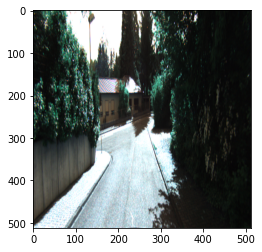

In [32]:
import matplotlib.pyplot as plt

plt.imshow(x[0].astype('uint8'))

In [37]:
pr = deeplab_model.predict(x)

(512, 512, 19)
(512, 512)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

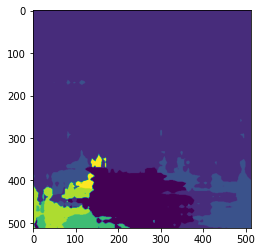

In [38]:
import numpy as np

res = pr[0]
print(res.shape)
res = np.argmax(res.squeeze(), -1)
print(res.shape)
print(res[0])
plt.imshow(res.astype('uint8'))